#  Practical 2 - ID5059

I confirm that this code is my own work, except where clearly indicated.

The first thing to do is to import packages that will be used.

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
import tensorflow as tf
from tensorflow import keras

For this practical I looked at a lot of different solutions to this problem and got ideas on dealing with cleaning the data, projects I used for helping me are: 

https://github.com/brunocampos01/porto-seguro-safe-driver-prediction/blob/master/notebooks/porto_seguro_safe_driver.ipynb

https://github.com/ngbolin/PortoSeguroXGB/blob/master/Porto%20Seguro%20Prediction.ipynb

https://github.com/Jihenghuang/kaggle-porto-seguro/blob/master/porto-seguro-jiheng.ipynb


First we read in the data, making sure we mark the values -1 as missing values.

In [36]:
trainingData = pd.read_csv("~/Data/train.csv",na_values=-1)


In [37]:
testingData = pd.read_csv("~/Data/test.csv",na_values=-1)

In [6]:
trainingData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     594996 non-null float64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595129 non-null float64
ps_ind_05_cat     589403 non-null float64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64

In [7]:
testingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
id                892816 non-null int64
ps_ind_01         892816 non-null int64
ps_ind_02_cat     892509 non-null float64
ps_ind_03         892816 non-null int64
ps_ind_04_cat     892671 non-null float64
ps_ind_05_cat     884106 non-null float64
ps_ind_06_bin     892816 non-null int64
ps_ind_07_bin     892816 non-null int64
ps_ind_08_bin     892816 non-null int64
ps_ind_09_bin     892816 non-null int64
ps_ind_10_bin     892816 non-null int64
ps_ind_11_bin     892816 non-null int64
ps_ind_12_bin     892816 non-null int64
ps_ind_13_bin     892816 non-null int64
ps_ind_14         892816 non-null int64
ps_ind_15         892816 non-null int64
ps_ind_16_bin     892816 non-null int64
ps_ind_17_bin     892816 non-null int64
ps_ind_18_bin     892816 non-null int64
ps_reg_01         892816 non-null float64
ps_reg_02         892816 non-null float64
ps_reg_03         731132 non-null float

Our first step is to take a look at the data and analyse which variables we should keep and how to deal with missing values. We make a seperate dataset with columns that have missing values and print out a table of the numbers of missing values. 

In [38]:
missingData = trainingData.columns[trainingData.isnull().any()].tolist()

missingDataset = trainingData[missingData]

In [39]:
missingDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 13 columns):
ps_ind_02_cat    594996 non-null float64
ps_ind_04_cat    595129 non-null float64
ps_ind_05_cat    589403 non-null float64
ps_reg_03        487440 non-null float64
ps_car_01_cat    595105 non-null float64
ps_car_02_cat    595207 non-null float64
ps_car_03_cat    183981 non-null float64
ps_car_05_cat    328661 non-null float64
ps_car_07_cat    583723 non-null float64
ps_car_09_cat    594643 non-null float64
ps_car_11        595207 non-null float64
ps_car_12        595211 non-null float64
ps_car_14        552592 non-null float64
dtypes: float64(13)
memory usage: 59.0 MB


In [10]:
numberOfNas = missingDataset.isnull().sum().sort_values(ascending = False)
numberOfNas = pd.DataFrame({"Missing values": numberOfNas})
numberOfNas.head(13)

Missing values
ps_car_03_cat          411231
ps_car_05_cat          266551
ps_reg_03              107772
ps_car_14               42620
ps_car_07_cat           11489
ps_ind_05_cat            5809
ps_car_09_cat             569
ps_ind_02_cat             216
ps_car_01_cat             107
ps_ind_04_cat              83
ps_car_11                   5
ps_car_02_cat               5
ps_car_12                   1

In [11]:
numberOfNasPercentage = missingDataset.isnull().sum().sort_values(ascending = False) / 595212
numberOfNasPercentage = pd.DataFrame({"Missing values": numberOfNasPercentage})
numberOfNasPercentage.head(13)

Missing values
ps_car_03_cat        0.690898
ps_car_05_cat        0.447825
ps_reg_03            0.181065
ps_car_14            0.071605
ps_car_07_cat        0.019302
ps_ind_05_cat        0.009760
ps_car_09_cat        0.000956
ps_ind_02_cat        0.000363
ps_car_01_cat        0.000180
ps_ind_04_cat        0.000139
ps_car_11            0.000008
ps_car_02_cat        0.000008
ps_car_12            0.000002

After analysing the missing values it can be seen that two variables have more than 40 percent of their values missing. These variables will be removed since it will be hard to fill such a large part of them in a good way. 

Next up is to make a correlation plot of all the variables to analyse the variables further.

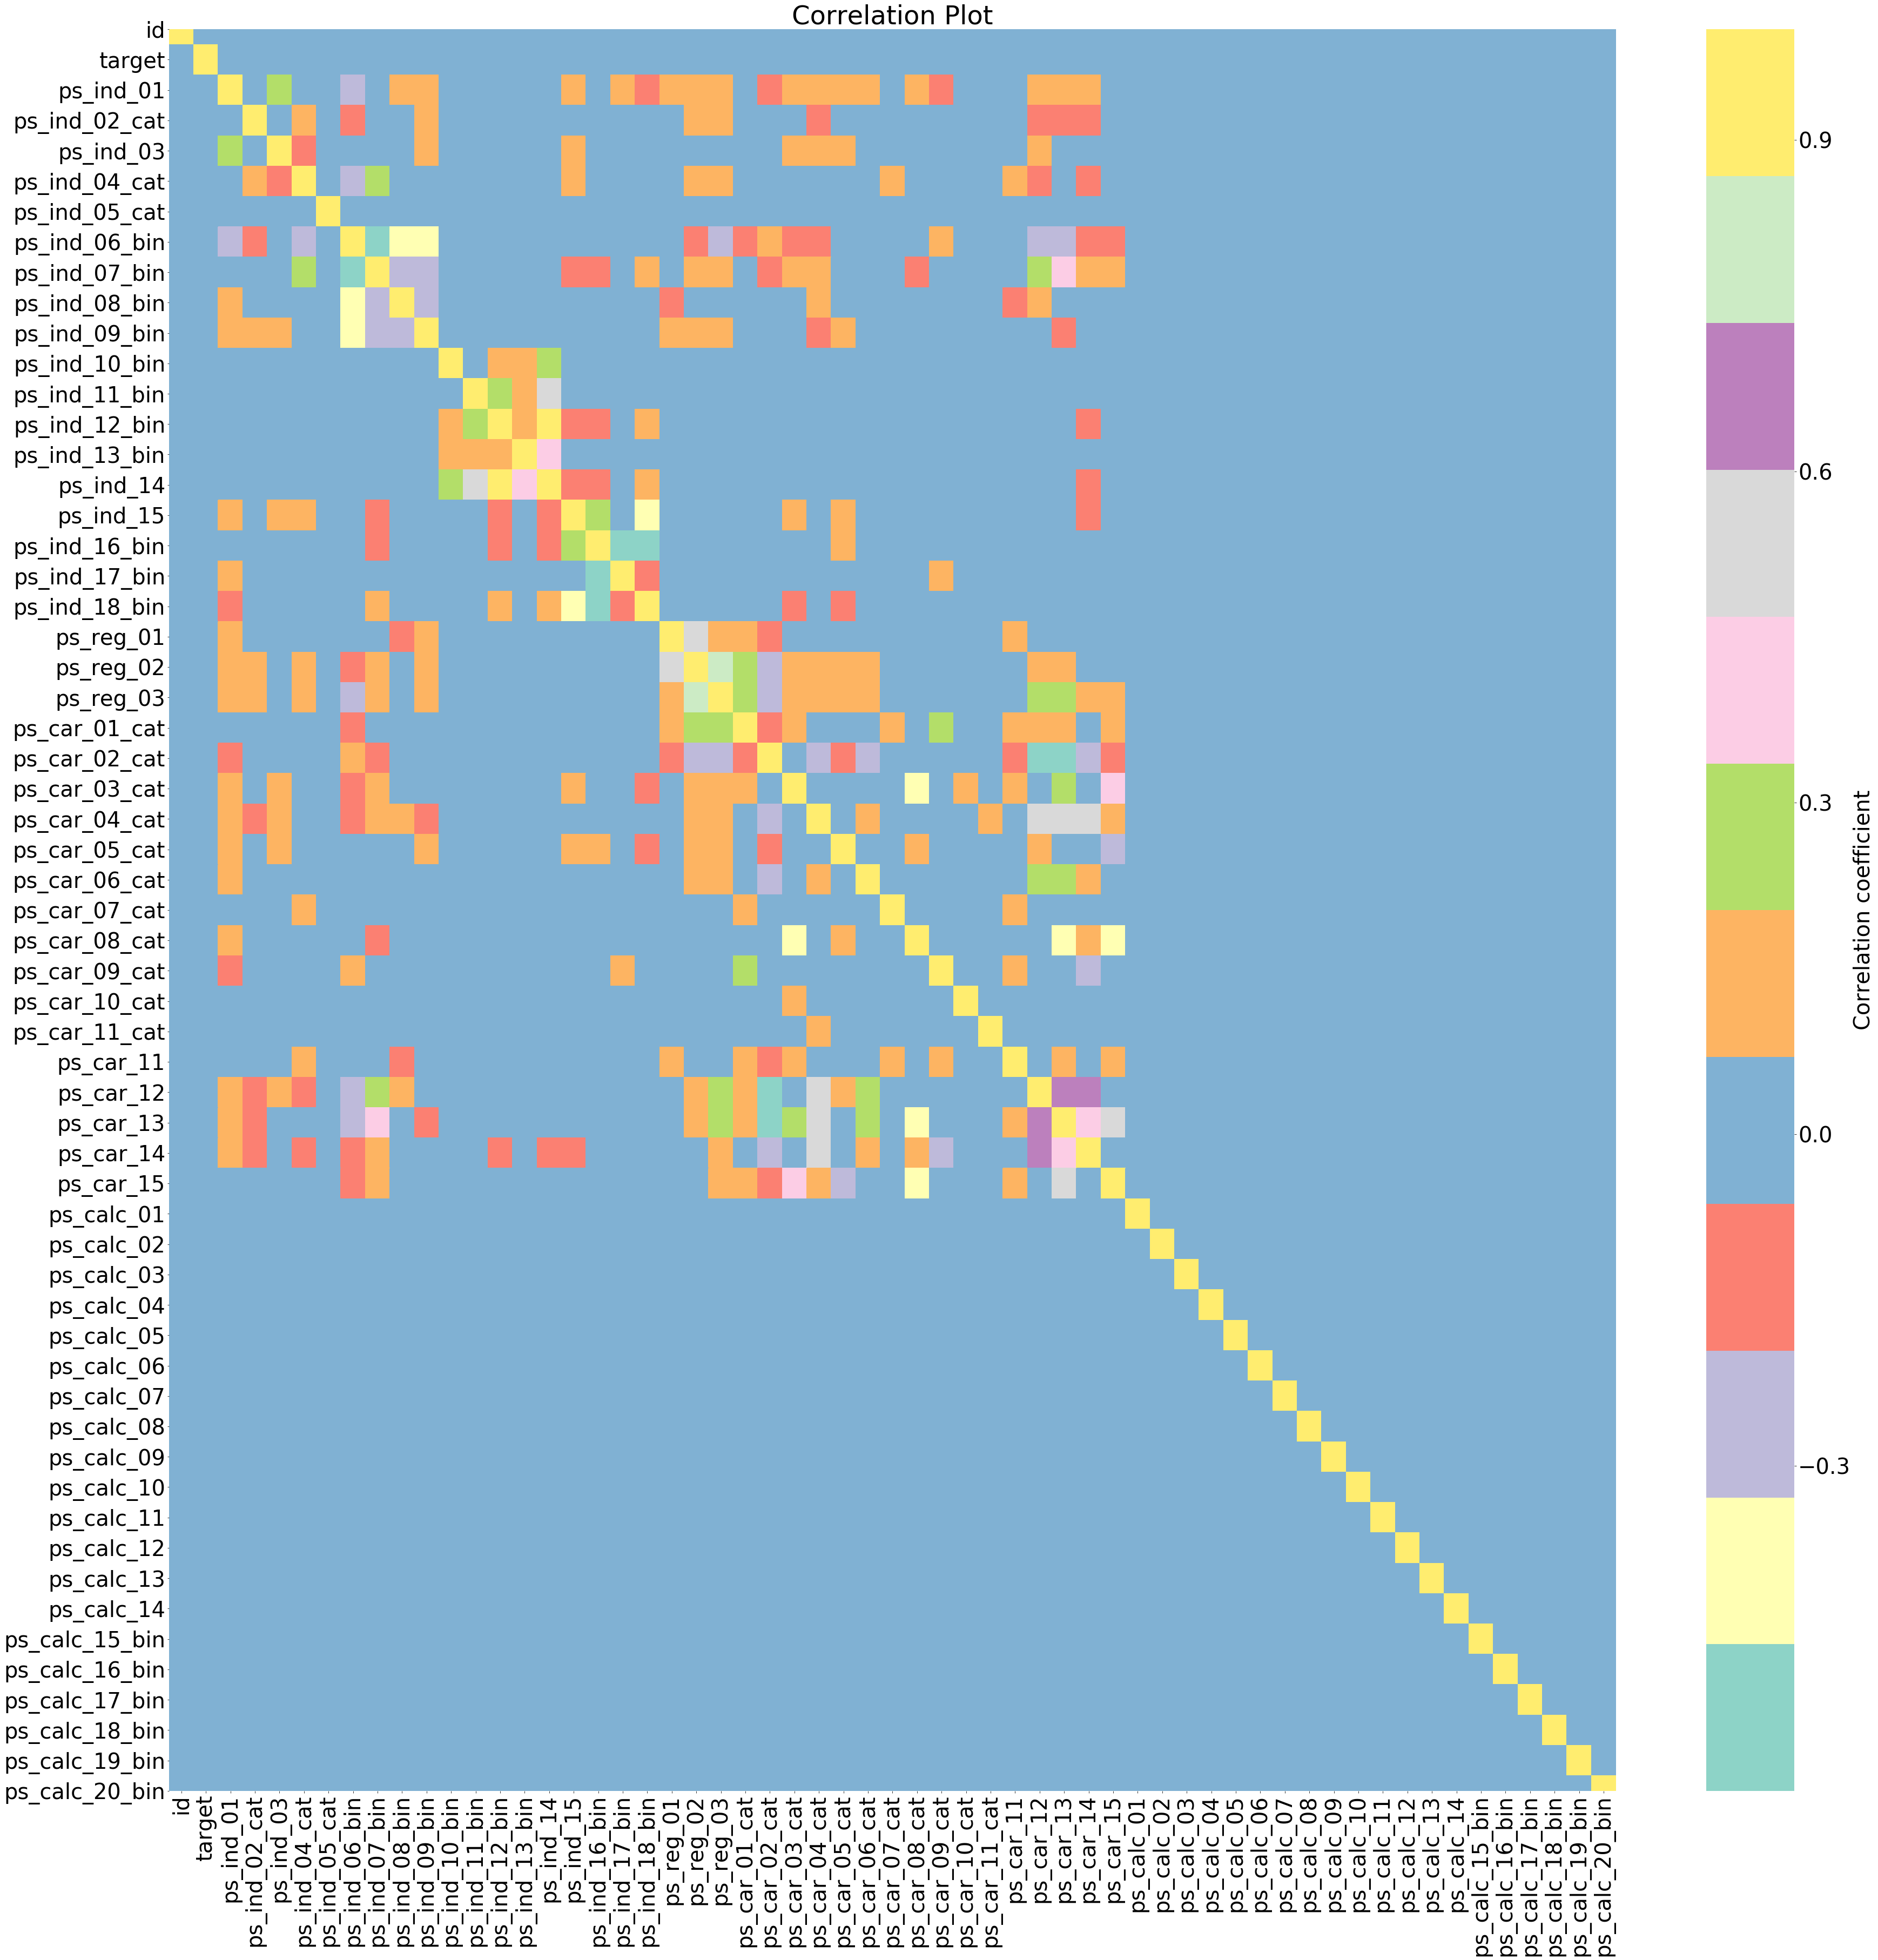

In [65]:
plt.rcParams.update({'font.size': 40})
corrMatrix = trainingData.corr()
plt.figure(figsize=(60,60))
plt.title("Correlation Plot")
sns.heatmap(corrMatrix,cmap='Set3',cbar_kws={'label': 'Correlation coefficient'})

In [40]:
trainingData1 = trainingData.copy()
testingData1 = testingData.copy()

From the plot above it can be seen that variables with "calc" in the name are not correlated to anything so they don't seem to be important as a predictor. They will alll be removed to safe computing time.

Now we remove the variables that won't be used

In [42]:
trainingData1 = trainingData1.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)
testingData1 = testingData1.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)
missingDataset = missingDataset.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)

In [43]:
dropVars = trainingData1.columns[trainingData1.columns.str.startswith('ps_calc')] 
trainingData1 = trainingData1.drop(dropVars,axis =1)
testingData1 = testingData1.drop(dropVars,axis=1)

For dealing with missing values we will try three methods. We have continous variables with missing values and categorical variables. 
The first method is to fill the continous variables with the median value and to fill the categorical with the most common value.

The second method is to fill the continous variables with the median value and to to add a seperate category for missing values for the categorical variables.

The third method is to interpolate the continuos variables so the distribution will be more even. 

These methods will be compared by fitting a model to each model and compare the results. If method 3  and method 2 beats method 1 we will both interpolate continous variables and have a seperate category for categorical variables.

In [44]:
missingCatVars = missingDataset.columns[missingDataset.columns.str.endswith('cat')] 
missingContVars = missingDataset.columns[~missingDataset.columns.str.endswith('cat')]

In [45]:
trainingData2= trainingData1.copy() 
testingData2 = testingData1.copy()

trainingData3= trainingData1.copy() 
testingData3 = testingData1.copy()

Below we fill the missing values with different methods. 

Method 1:

In [46]:
for col in (missingCatVars):
    trainingData1[col].fillna(value=trainingData1[col].mode()[0], inplace=True)
    testingData1[col].fillna(value=testingData1[col].mode()[0], inplace=True)


In [47]:
for col in (missingContVars):
    trainingData1[col].fillna(value=trainingData1[col].median(), inplace=True)
    testingData1[col].fillna(value=testingData1[col].median(), inplace=True)

Method 2: 

In [48]:
for col in (missingCatVars):
    trainingData2[col].fillna(value=-1, inplace=True)
    testingData2[col].fillna(value=-1, inplace=True)


In [49]:
for col in (missingContVars):
    trainingData2[col].fillna(value=trainingData2[col].median(), inplace=True)
    testingData2[col].fillna(value=testingData2[col].median(), inplace=True)

Method 3:

In [50]:
for col in (missingCatVars):
    trainingData3[col].fillna(value=trainingData3[col].mode()[0], inplace=True)
    testingData3[col].fillna(value=testingData3[col].mode()[0], inplace=True)

In [51]:
for col in (missingContVars):
    trainingData3[col].interpolate(method ='linear',inplace = True)

To see the difference between the methods lets look at a histogram of the variables. We see the biggest difference for method 3 when the continous variables have a more balanced distribution.

In [52]:
#DROP IDS FIRST NOT RELEVANT IN PLOT
trainingData1 = trainingData1.drop(["id"], axis =1)
trainingData2 = trainingData2.drop(["id"], axis =1)
trainingData3 = trainingData3.drop(["id"], axis =1)

Method 1:

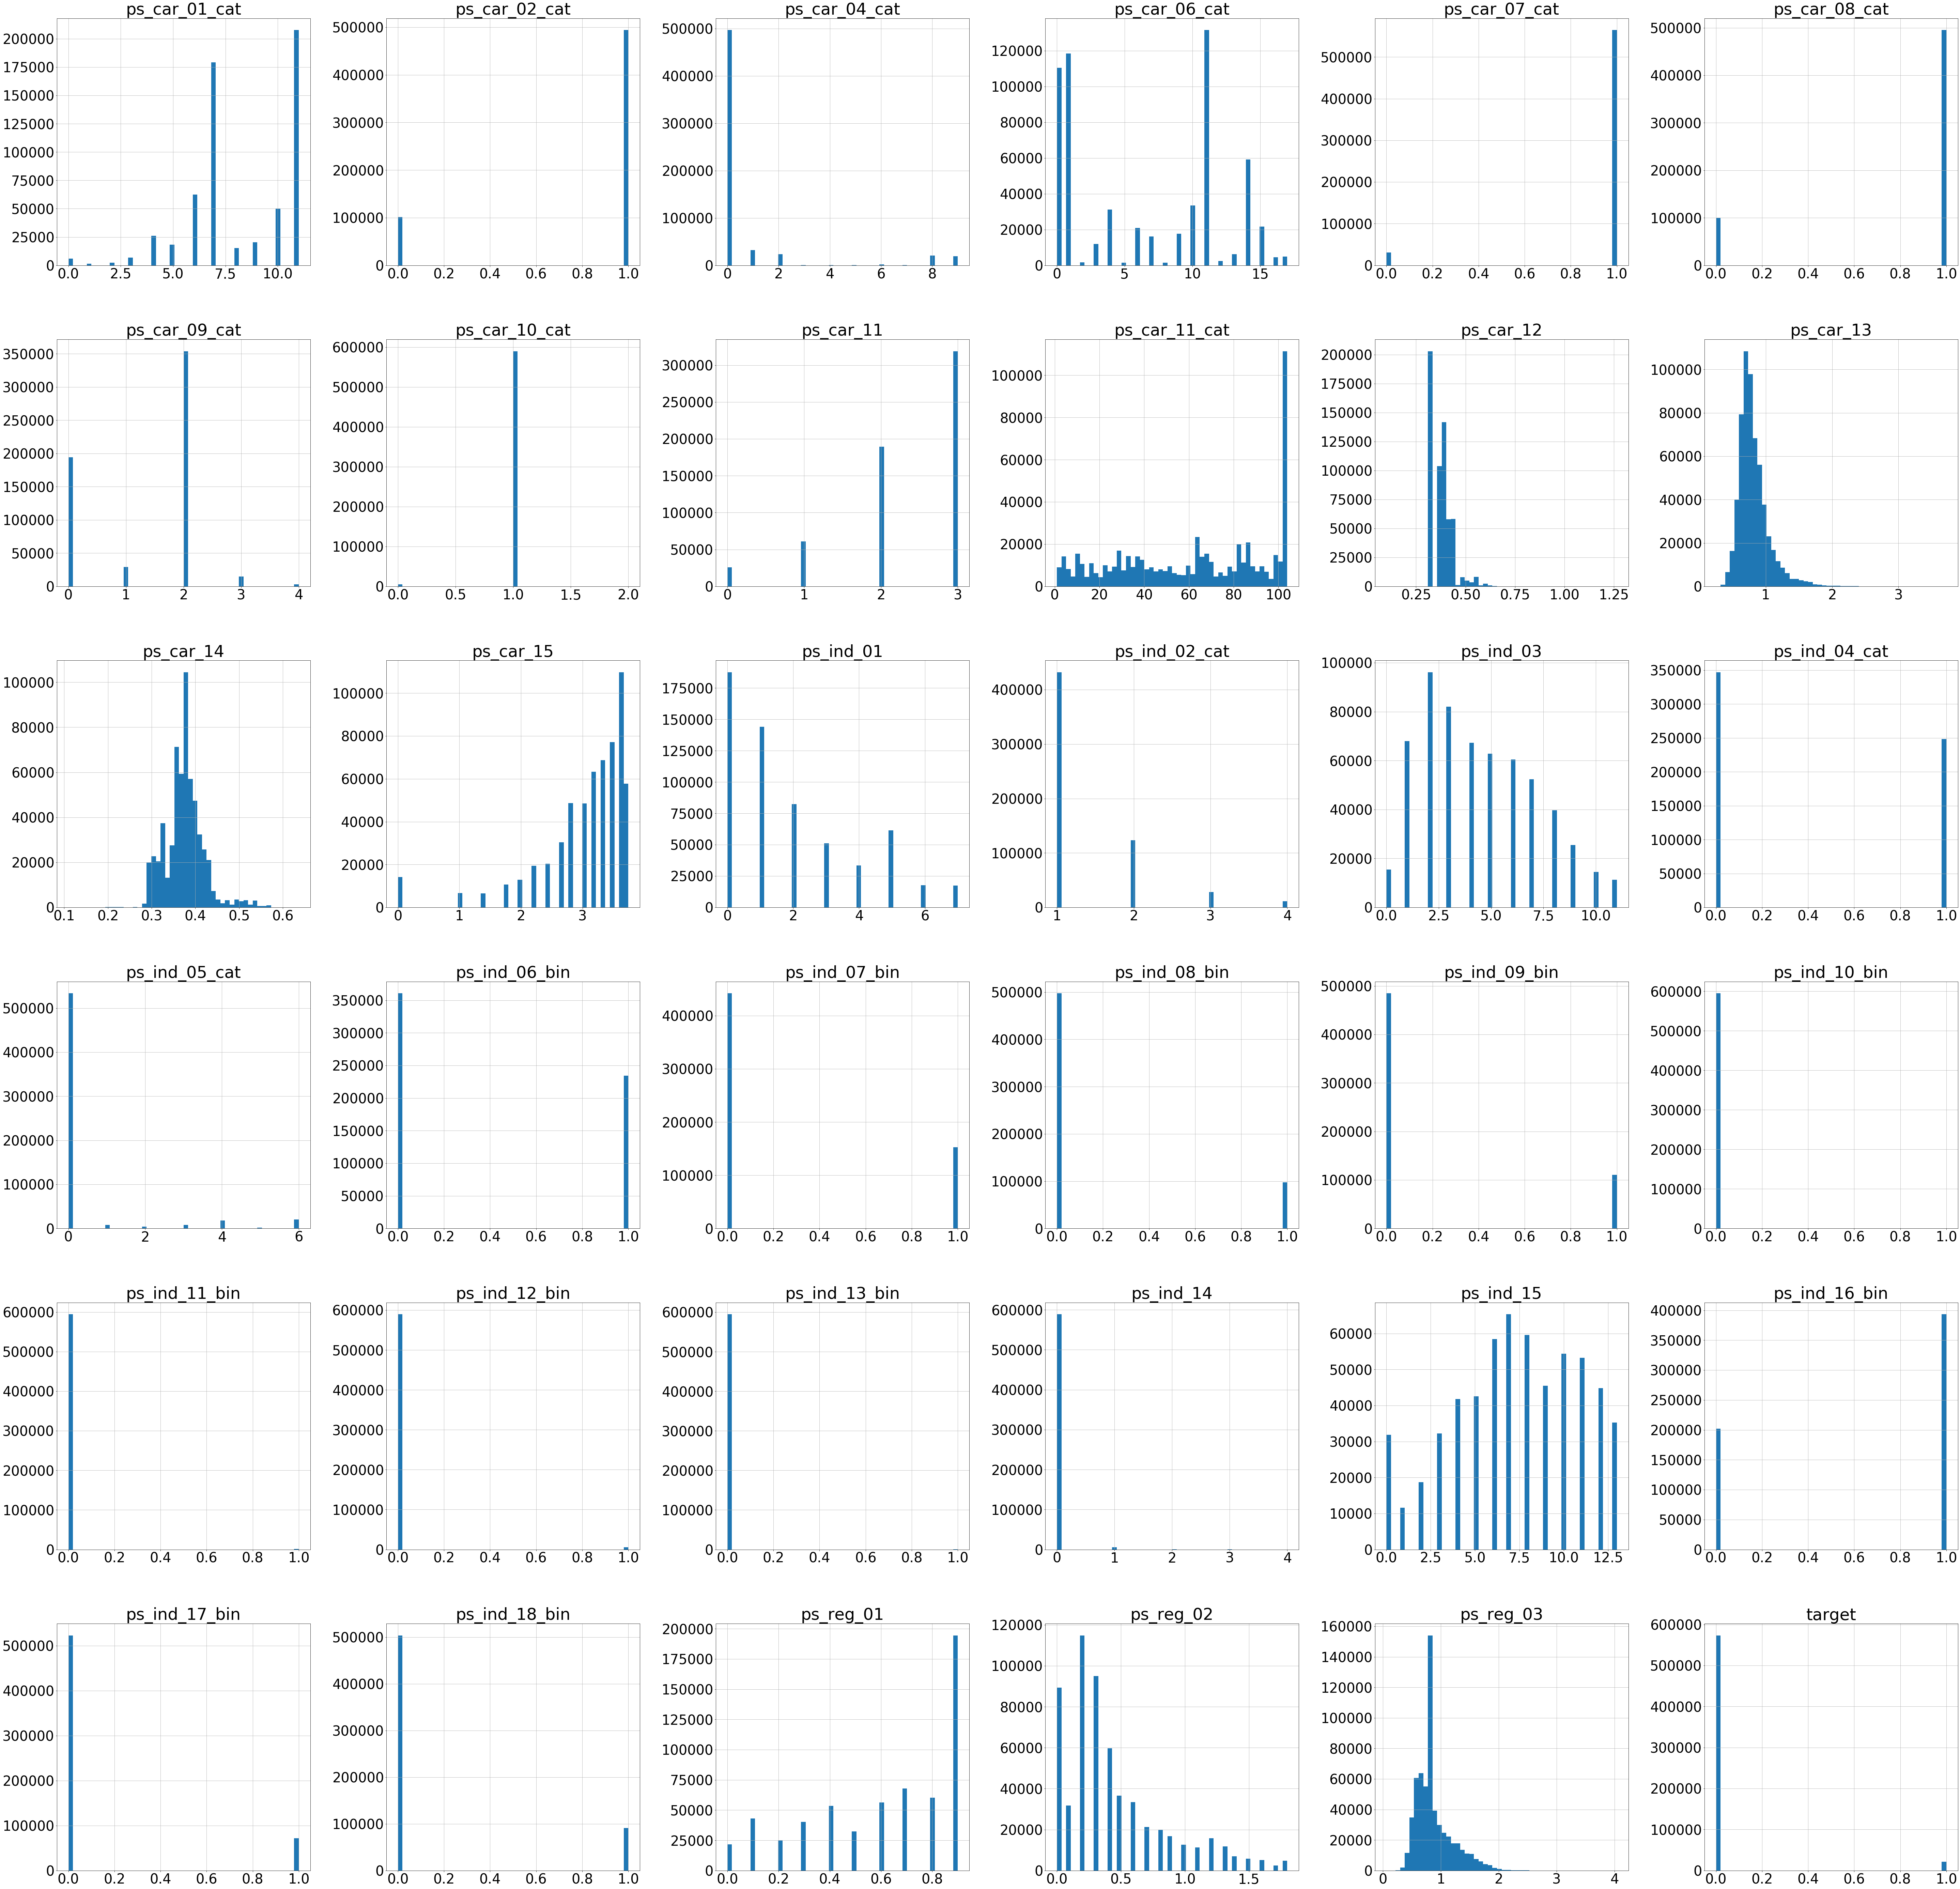

In [66]:
myFigure = trainingData1.hist(bins=50,figsize=(100,100))
plt.show()

Method 2:

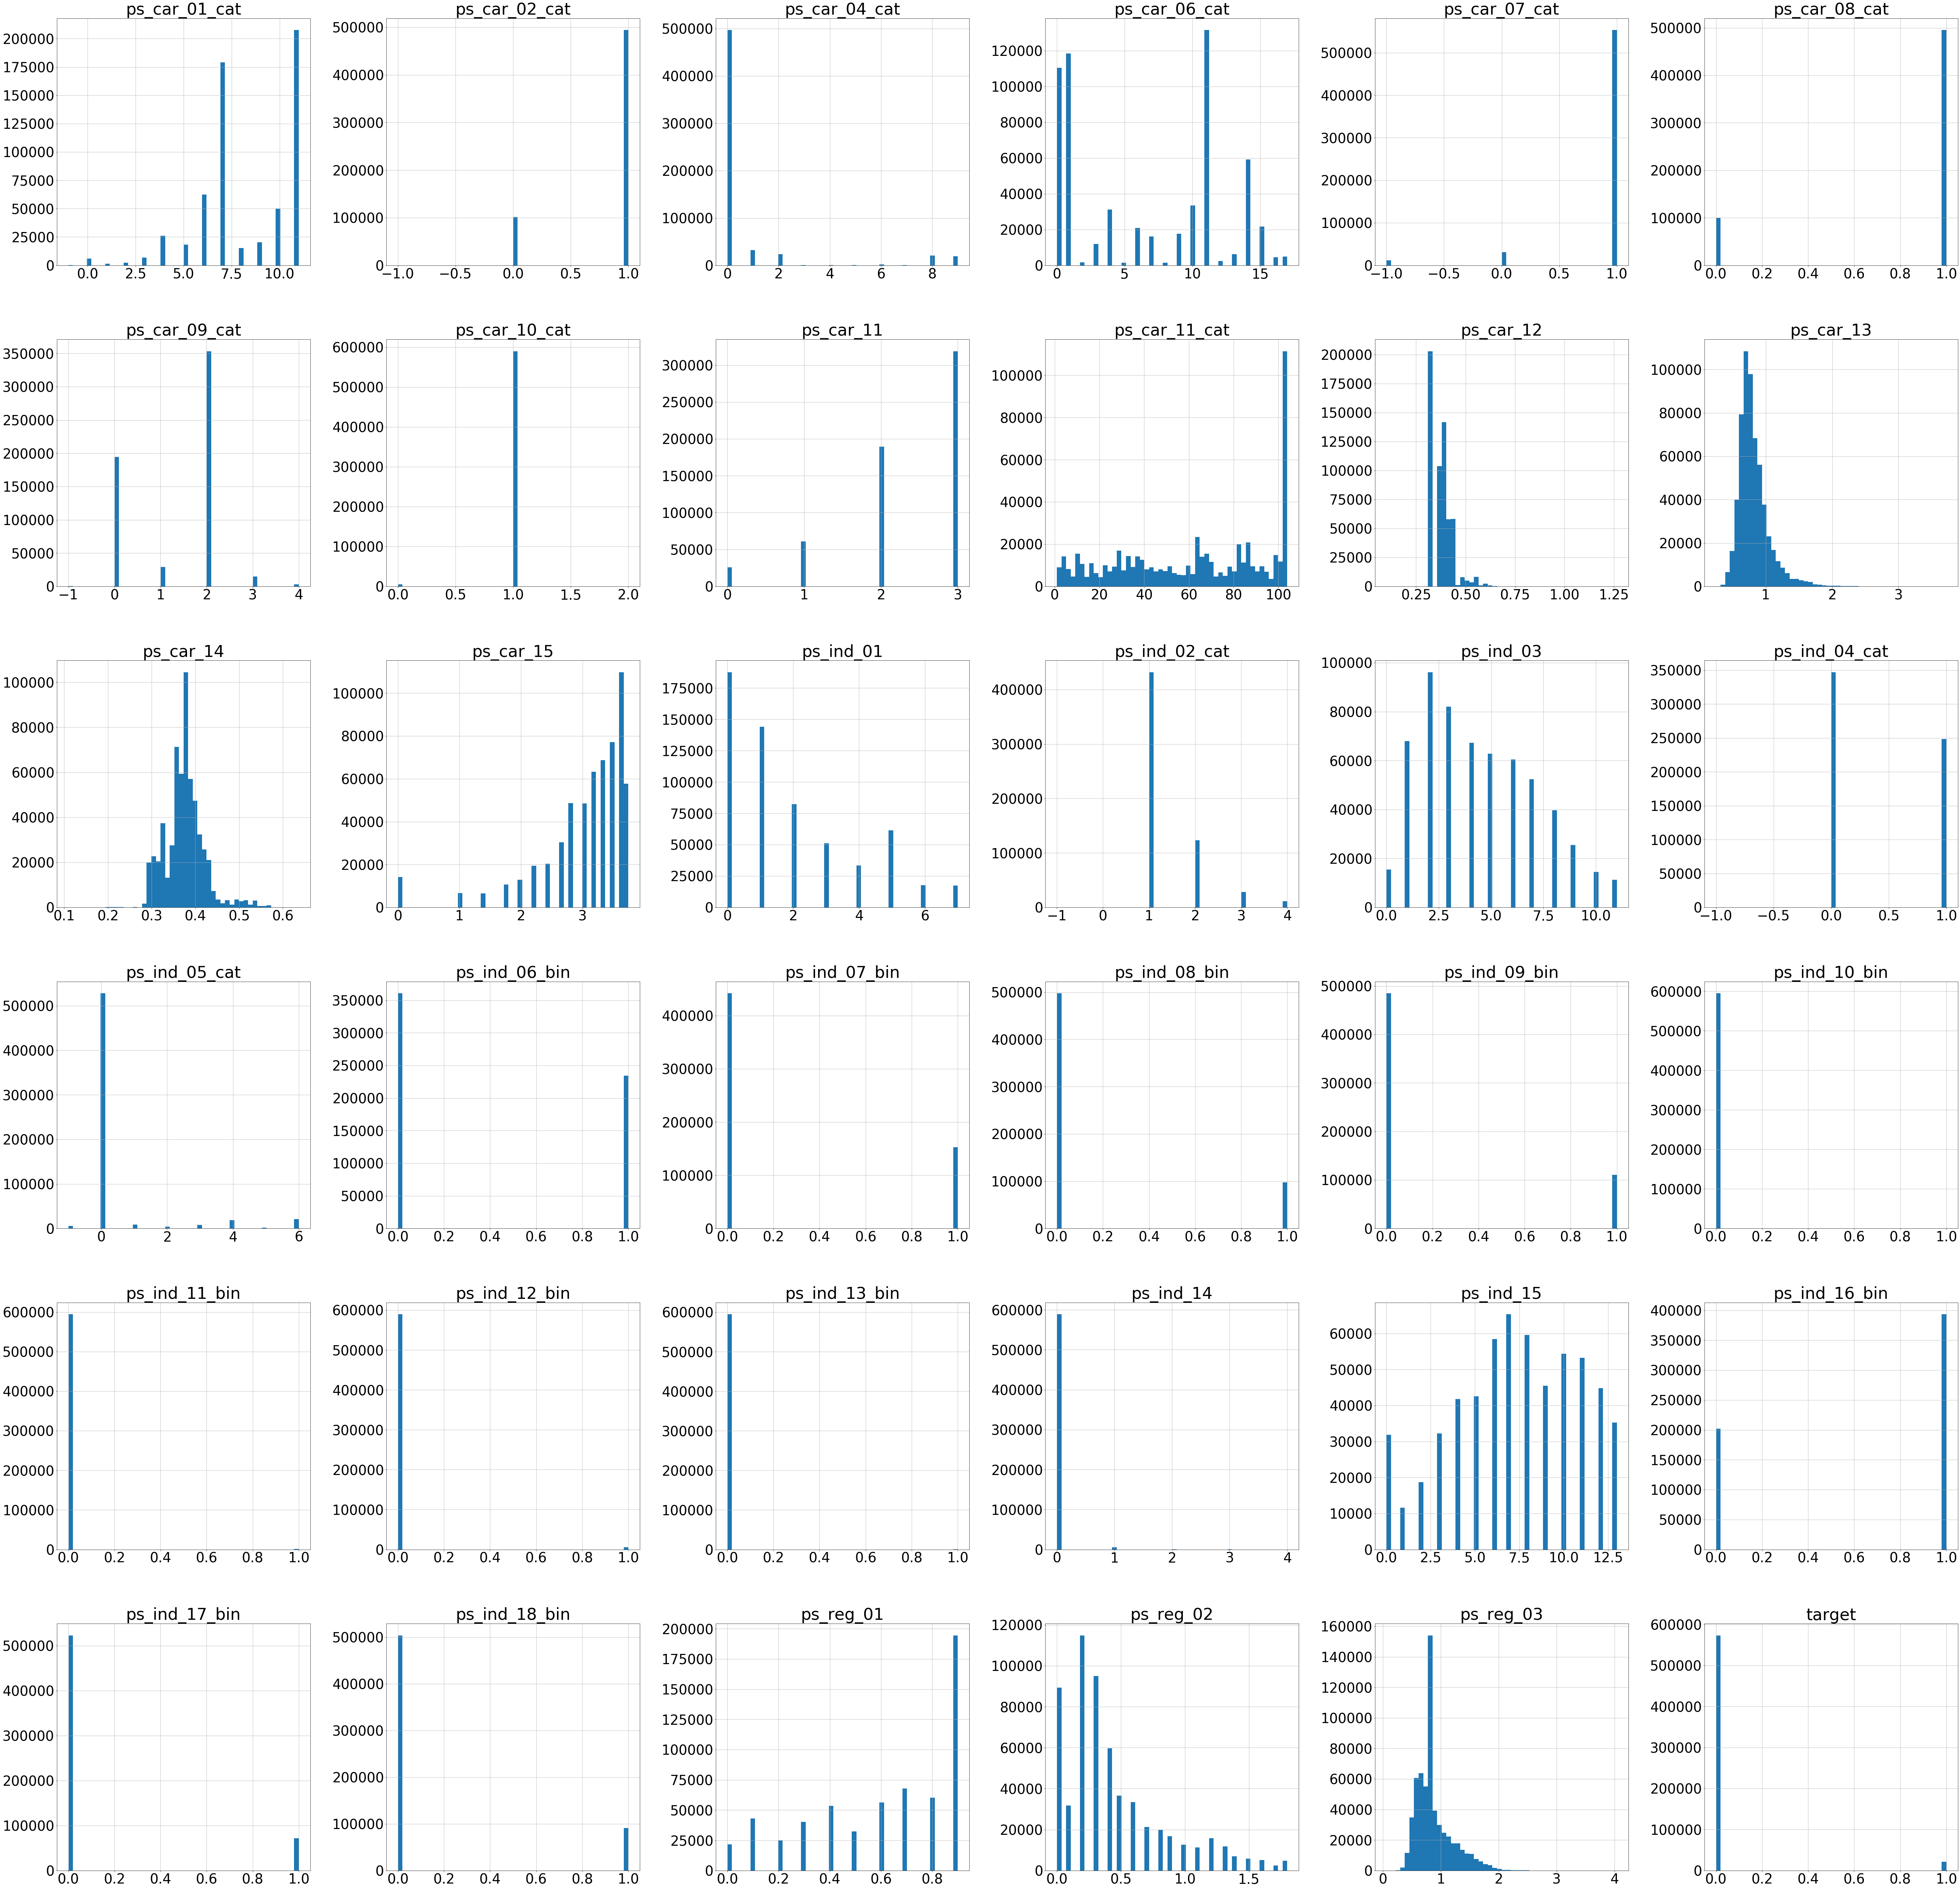

In [67]:
myFigure2 = trainingData2.hist(bins=50,figsize=(100,100))
plt.show()

Method 3: 

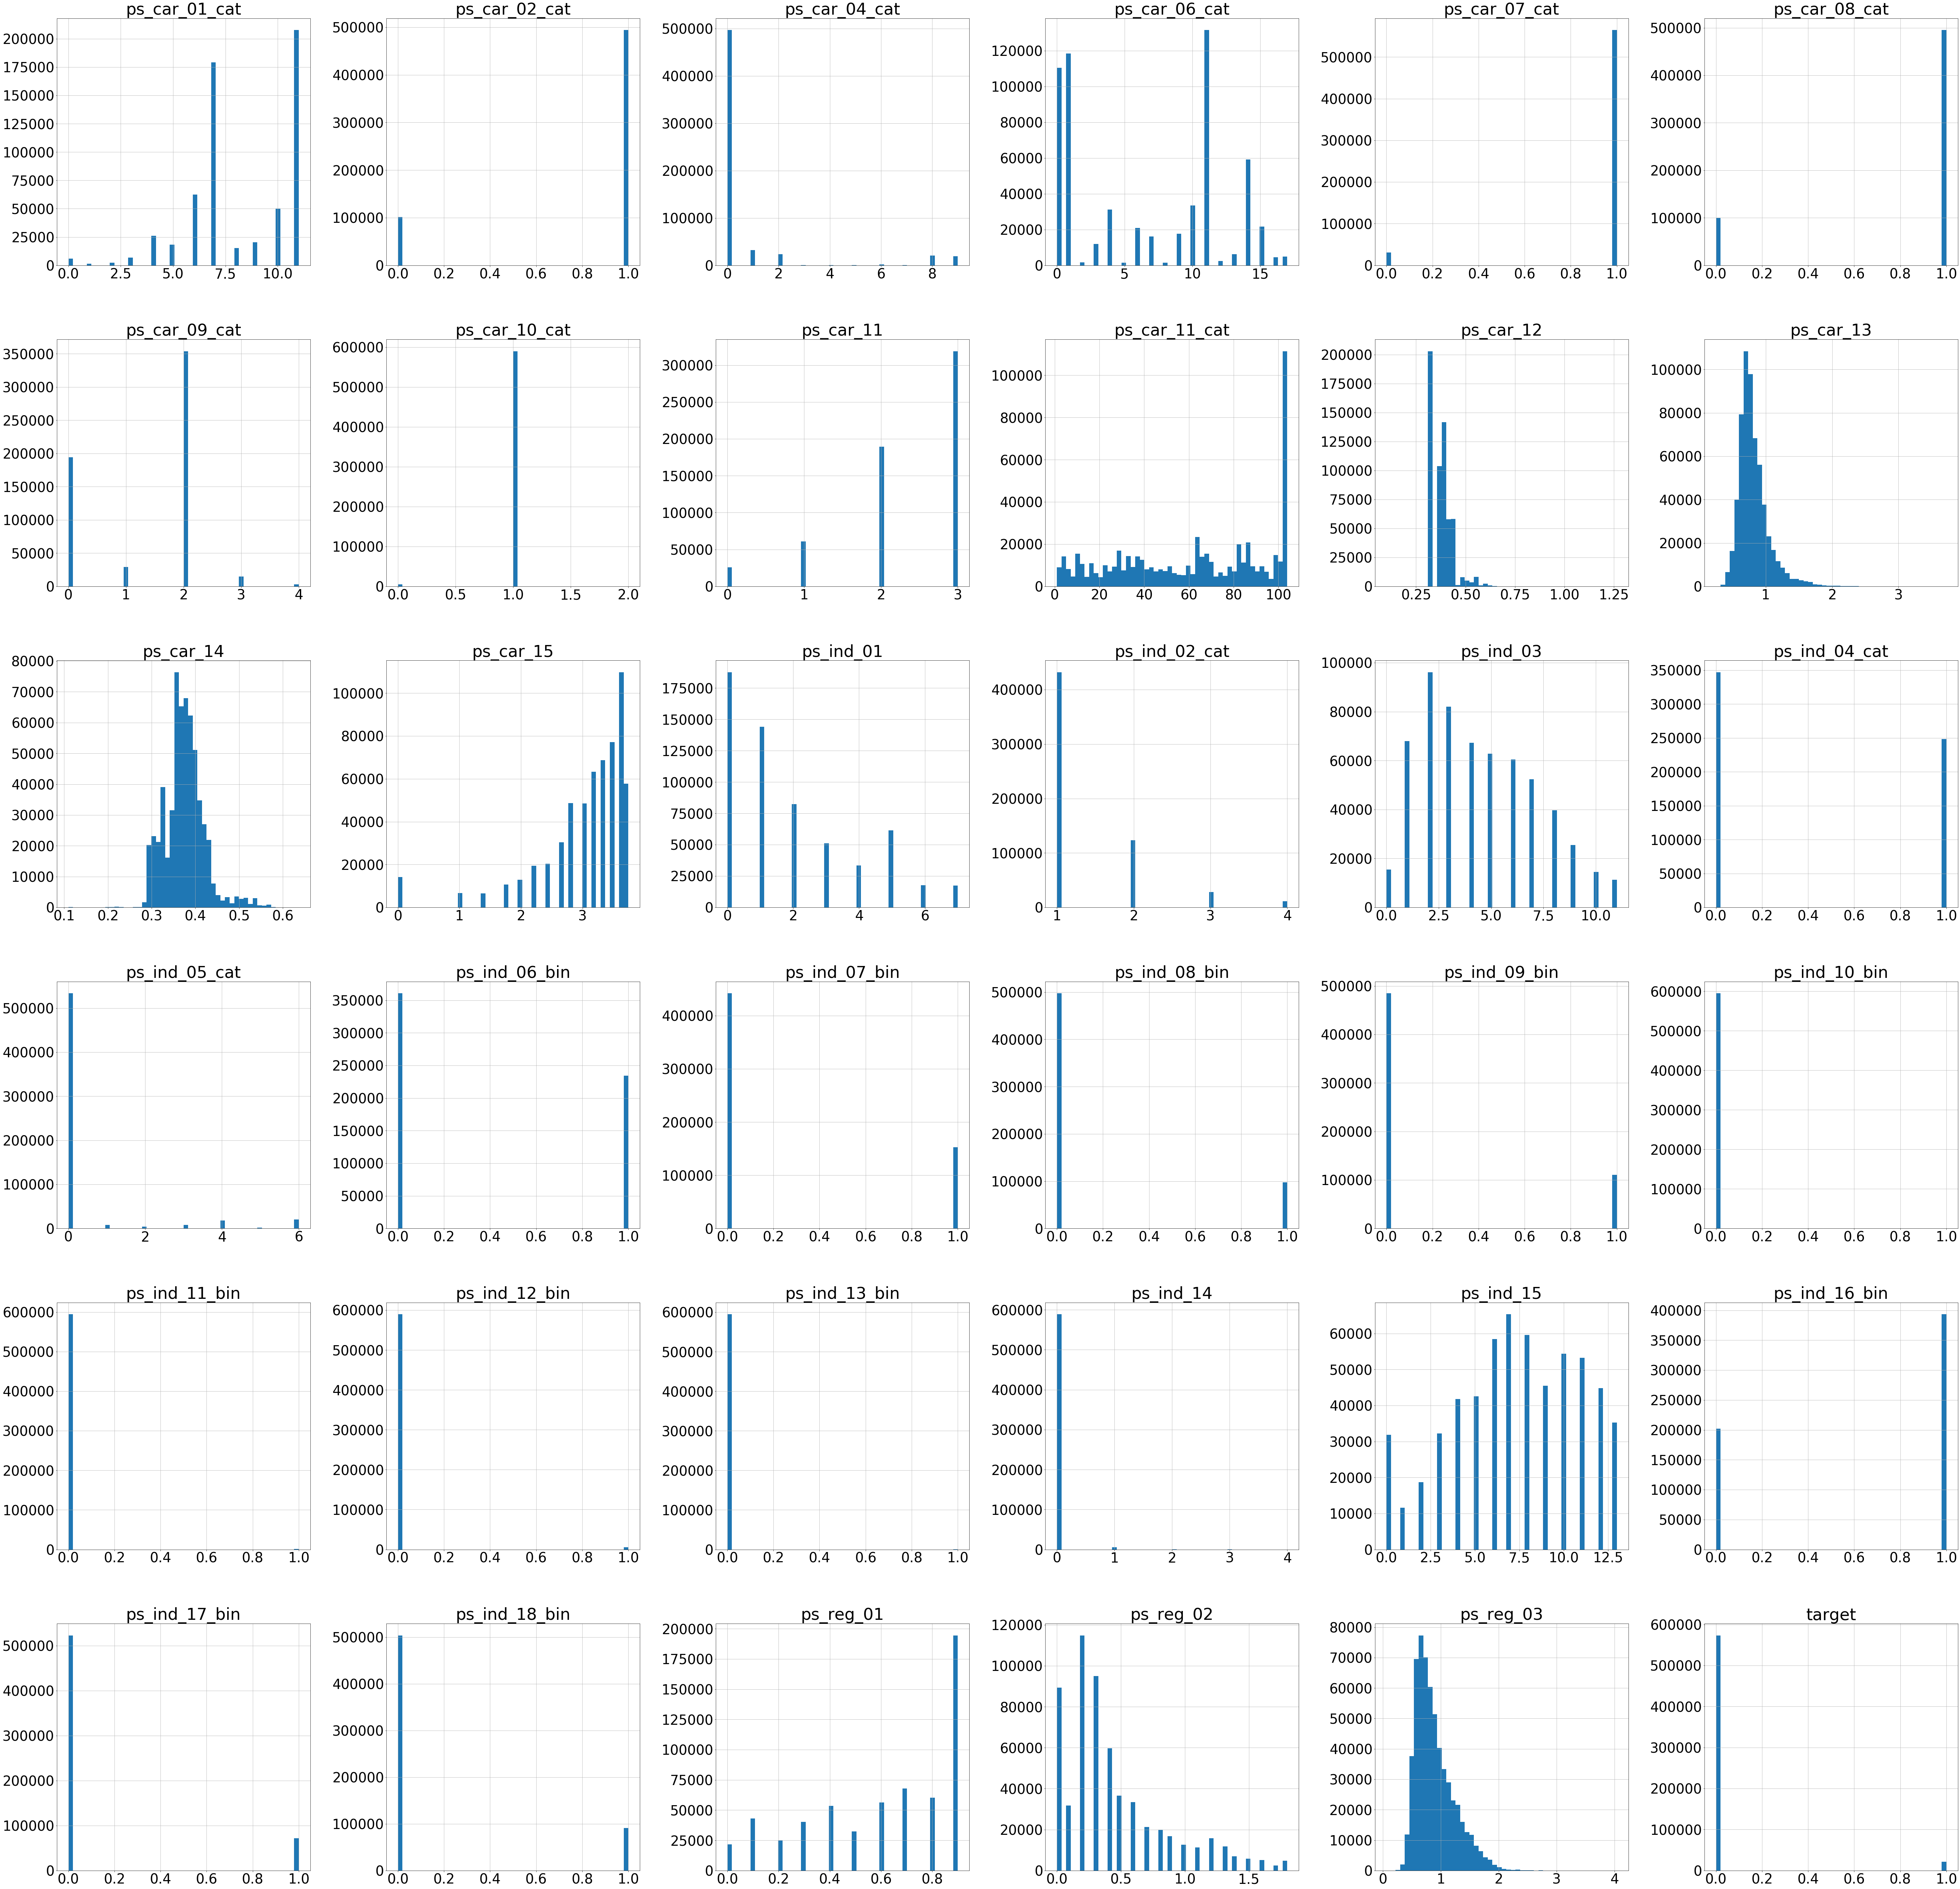

In [68]:
myFigure3 = trainingData3.hist(bins=50,figsize=(100,100))
plt.show()

Add dummy variables for all categorical variables for all datasets

In [24]:
dummyVars = trainingData1.columns[trainingData1.columns.str.endswith('cat')] 

In [25]:
dummyVars

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [26]:
trainingData1 = pd.get_dummies(trainingData1, columns=dummyVars)
testingData1 = pd.get_dummies(testingData1, columns=dummyVars)

In [27]:
trainingData2 = pd.get_dummies(trainingData2, columns=dummyVars)
testingData2 = pd.get_dummies(testingData2, columns=dummyVars)

In [28]:
trainingData3 = pd.get_dummies(trainingData3, columns=dummyVars)
testingData3 = pd.get_dummies(testingData3, columns=dummyVars)

Make data ready for fitting

In [29]:
modelData = trainingData1.copy()
testData = testingData1.drop(['id'],axis = 1)
response = trainingData1['target']
modelData = modelData.drop(['target'],axis = 1)


In [30]:
modelData2 = trainingData2.copy()
testData2= testingData2.drop(['id'],axis = 1)
response2 = trainingData2['target']
modelData2 = modelData2.drop(['target'],axis = 1)

In [31]:
modelData3 = trainingData3.copy()
testData3= testingData3.drop(['id'],axis = 1)
response3 = trainingData3['target']
modelData3 = modelData3.drop(['target'],axis = 1)

Fit logistic regression model on all methods, this will be our baseline model.

Method 1:

In [162]:
#Solver added to model to silence a future warning about change of solver
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='liblinear')
logmodel.fit(modelData,response)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Method 2: 

In [163]:
from sklearn.linear_model import LogisticRegression
logmodel2 = LogisticRegression(solver='liblinear')
logmodel2.fit(modelData2,response2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Method 3: 

In [164]:
from sklearn.linear_model import LogisticRegression
logmodel3 = LogisticRegression(solver='liblinear')
logmodel3.fit(modelData3,response3)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Compare all the models with cross validation where we use the roc_auc score as an evaluation metric

In [165]:
from sklearn.model_selection import cross_val_score
score1 = cross_val_score(logmodel, modelData, response, cv=5, scoring="roc_auc")
score1

array([0.62789311, 0.62574581, 0.62697671, 0.62786427, 0.62447454])

In [166]:
from sklearn.model_selection import cross_val_score
score2 = cross_val_score(logmodel2, modelData2, response2, cv=5, scoring="roc_auc")
score2

array([0.6303205 , 0.62888478, 0.63002405, 0.62902797, 0.62723738])

In [167]:
from sklearn.model_selection import cross_val_score
score3 = cross_val_score(logmodel3, modelData3, response3, cv=5, scoring="roc_auc")
score3

array([0.62788349, 0.62546537, 0.62689708, 0.62751361, 0.62425388])

Method 1: 

In [168]:
np.mean(score1)


0.6265908894044667

Method 2: 

In [169]:
np.mean(score2)

0.6290989334939049

Method 3: 

In [170]:
np.mean(score3)

0.6264026853974541

The results indicate that the data with categories for the missing data gives the best results.This is method 2. Method 3 showed no signs of improvement over method 1 so we will keep the continous variables filled with the median values. We will use data filled with method 2 to fit more models with logistic regression as the baseline model


Finally we fit the model on the unseen test dataset and upload a submission to kaggle with our baseline model. The public score calculated was 0.258.

In [171]:
myIds = testingData['id']
testResults = logmodel2.predict_proba(testData2)

submission = pd.DataFrame( { 'id': myIds , 'target': testResults[:,1]} )
submission = submission[['id', 'target']]

submission.to_csv("submission1.csv", index = False)

Next up we fit a random forest classifier, we start with 200 estimators with a max depth of 6

In [148]:
#Fit random forest model
from sklearn.ensemble import RandomForestClassifier
ranforClass = RandomForestClassifier(n_estimators = 200, max_depth = 6)
ranforClass.fit(modelData2, response2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [156]:
import numpy as np
from sklearn.model_selection import cross_val_score
myScores2 = cross_val_score(ranforClass, modelData2, response2,  scoring="roc_auc", cv=5)
myScores2

array([0.62698739, 0.62442246, 0.62780614, 0.62402964, 0.62570456])

In [157]:
np.mean(myScores2)

0.6257900386559425

This model does not beat the roc_auc score of our baseline model. We will try to finetune our model by selecting different values for max depth and number of estimators. My laptop does not have great computing power so I did not pick many different values and used RandomisedSearchCV instead of GridSearchCV.

In [174]:
from sklearn.model_selection import RandomizedSearchCV
myParams = {"max_depth": [4,6,8,10],
               "n_estimators": [10,100,200,500],}
 
myClassifierModel= RandomForestClassifier()
grid_search = RandomizedSearchCV(myClassifierModel, myParams, cv = 5, random_state=190030150, scoring = 'roc_auc',return_train_score=True)

In [175]:
grid_search.fit(modelData2,response2)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [176]:
bestRfModel = grid_search.best_estimator_
bestRfModel

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

The best model returned has 10 as max depth and 200 as number of estimators. Lets estimate the roc auc score for that one with cross validation

In [177]:
bestRfModel.fit(modelData2, response2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [178]:
import numpy as np
from sklearn.model_selection import cross_val_score
myScores3 = cross_val_score(bestRfModel, modelData2, response2,  scoring="roc_auc", cv=5)
myScores3

array([0.63187556, 0.62983718, 0.63259835, 0.62975162, 0.63038756])

In [179]:
np.mean(myScores3)

0.6308900537548509

This is a slight improvement from the previous logistic model. We fit the model on the unseen test dataset and get a score of 0.256 which is lower than our baseline score. This indicates that the model fit slightly worse on our unseen dataset than the logistic regression.

In [180]:
myIds = testingData['id']
testResults = bestRfModel.predict_proba(testData2)

submission = pd.DataFrame( { 'id': myIds , 'target': testResults[:,1]} )
submission = submission[['id', 'target']]

submission.to_csv("submission2.csv", index = False)
submission.head(10)

id    target
0   0  0.027451
1   1  0.027675
2   2  0.034672
3   3  0.021452
4   4  0.033839
5   5  0.038438
6   6  0.032107
7   8  0.033371
8  10  0.053814
9  11  0.051501

Next up we try AdaBoost, we fit it with 200 estimators and a learning rate of 0.5

In [162]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [32]:
boostModel = AdaBoostClassifier(n_estimators=200,
 algorithm="SAMME.R", learning_rate=0.5)
boostModel.fit(modelData2, response2)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=200, random_state=None)

In [33]:
import numpy as np
from sklearn.model_selection import cross_val_score
myScores3 = cross_val_score(boostModel, modelData2, response2,  scoring="roc_auc", cv=5)
myScores3

array([0.63502014, 0.63539946, 0.63457668, 0.63658252, 0.63077524])

In [34]:
np.mean(myScores3)

0.6344708052294219

The roc auc score indicates an even better score than the random forest classifier, lets try to finetune it by trying different values for the hyperparameters, that is learning rate and number of estimators. 

In [167]:
from sklearn.model_selection import RandomizedSearchCV
myParams2 = {"n_estimators": [10,200,500],
 'learning_rate' : [0.01,0.1,0.5],}
boostModel2 = AdaBoostClassifier(algorithm="SAMME.R")

boostModel2 = AdaBoostClassifier()
grid_search2 = RandomizedSearchCV(boostModel2, myParams2, cv = 3, random_state=190030150, scoring = 'roc_auc',return_train_score=True)

In [168]:
grid_search2.fit(modelData2,response2)

C:\Users\LethalValdi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5],
                                        'n_estimators': [10, 200, 500]},
                   pre_dispatch='2*n_jobs', random_state=190030150, refit=True,
                   return_train_score=True, scoring='roc_auc', verbose=0)

In [169]:
bestAdaModel = grid_search2.best_estimator_
bestAdaModel

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=200, random_state=None)

After finetuning the hyperparameters we get the same hyperparameters as in the beginning so we will use that model. We upload it to kaggle and get a score of 0.267

In [35]:
myIds = testingData['id']
testResults = boostModel.predict_proba(testData2)

submission = pd.DataFrame( { 'id': myIds , 'target': testResults[:,1]} )
submission = submission[['id', 'target']]

submission.to_csv("submission3.csv", index = False)
